# <center><font color=blue> Interpolación con curvas Bspline cúbicas </font></center>
   
<center><font color=blue> Modelado 3D. UPV/EHU </font></center>

El objetivo de esta práctica es crear un interpolador de curvas Bsplines
cúbicas. Esto es, dado un vector de puntos 2D ó 3D, generaremos la curva Bspline cúbica que pasa por todos ellos (**Bspline interpoladora**). 

Por ejemplo, en la siguiente figura podemos ver la curva (en rojo), los puntos a interpolar sobre la propia curva (en verde) y los puntos de control de la curva (azules y unidos mediante aristas azules).

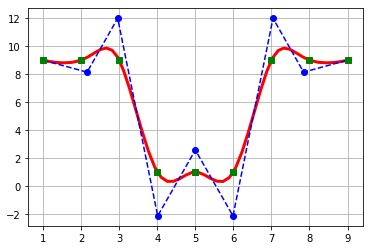

***

Hay tres posibles fases a realizar (incrementales):

1. En la primera fase (**<font color=red>OBLIGATORIA para todos</font>**) hay que implementar:  
    a. Cálculo de los nudos según el método de espaciado uniforme.  
    b. Visualización de la curva Bspline interpoladora.  
    c. Visualización de las funciones base de la curva interpoladora. 
    
    Una vez realizada esta fase podemos utilizar una serie de funciones ya implementadas en Python para visualizar nuestra curva en **Blender**. 

   
    
2. En la segunda fase, además de lo hecho en la primera, hay que implementar una nueva función que genere nudos no uniformes según el método *chord-length* o centrípeta.

3. En la tercera fase hay que obtener la derivada de la curva Bspline interpoladora, visualizarla así como sus funciones base.

Las dos últimas fases son opcionales.

***

La práctica es individual y las notas máximas asocidadas a cada fase son las siguientes:

|             | 1a.fase | 2a.fase | 3a.fase |
|-------------|---------|---------|---------|
| Nota máxima |    7    |    8    |    10   |


El fichero a entregar es este mismo documento (bien documentado) y sin errores.

La fecha de entrega de la práctica es el día establecido para la convocatoria
(primera o segunda) de la asignatura. 

## Primeros pasos

Para la interpolación de los puntos se va a utilizar una curva Bspline *clamped* de grado 3, y un vector con un número determinado de puntos a interpolar. 

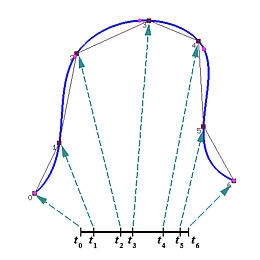

Hacemos corresponder un nudo a cada dato a interpolar.

<div>
   <img=src="attachment:interpolacion.jpg" width="360">
</div>


***

En nuestro caso, hemos creado una función que genera puntos 2D como puede apreciarse a continuación. No obstante, se pueden generar los datos que se deseen.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [22]:
### Funcion para generar datos de prueba
def creaDatosPrueba(caso):
    # Otra forma, sin funcion: 
    # data = np.asarray([[1, 9], [2, 9],[3, 9], [4 ,1], [5, 1], [6, 1], [7, 9], [8, 9], [9, 9] ])
    if (caso == 1):
        xrange = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
        yrange = np.array([9, 9, 9, 1, 1, 1, 9, 9, 9])
        zrange = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
    if (caso == 2):
        xrange = np.array([0.15, 0.4, 0.6, 0.9])
        yrange = np.array([0.1,  0.9, 0.9, 0.1])
        zrange = np.array([0.0,  0.0, 0.0, 0.0])
    if (caso == 3):
        xrange = np.array([0, 3, 3, 10])
        yrange = np.array([0, 4, 0, 0])
        zrange = np.array([0, 0, 0, 0])
    data  = np.vstack((xrange, yrange, zrange)).T
    return data

In [23]:
# Datos de prueba 1
data = creaDatosPrueba(1)
print("Numero de datos", len(data))
print(data)

Numero de datos 9
[[1 9 0]
 [2 9 0]
 [3 9 0]
 [4 1 0]
 [5 1 0]
 [6 1 0]
 [7 9 0]
 [8 9 0]
 [9 9 0]]


In [24]:
# Datos de prueba 2
data = creaDatosPrueba(2)
print("Numero de datos", len(data))
print(data)

Numero de datos 4
[[0.15 0.1  0.  ]
 [0.4  0.9  0.  ]
 [0.6  0.9  0.  ]
 [0.9  0.1  0.  ]]


In [25]:
# Datos de prueba 3
data = creaDatosPrueba(3)
print("Numero de datos", len(data))
print(data)

Numero de datos 4
[[ 0  0  0]
 [ 3  4  0]
 [ 3  0  0]
 [10  0  0]]


***

Una curva B-spline viene definida como:

\begin{equation}
P(u) = \sum_{i=0}^n p_i N_{i,p}(u)
\end{equation}

donde $0 = u_{3} <= u <= u_{n+1} = 1$ y las funciones básicas $N_{i,3}(u)$ se definen para el vector de nudos $u_0, u_1, \ldots u_m$ siendo los puntos de control $p_0, p_1, \ldots p_n$.

Esta función llama iterativamente a la función que devuelve el valor de la función base $N_{i,p}(u)$ y lo multiplica por el punto de control correspondiente y suma el producto al resultado final.

In [26]:
### Definicion de una curva Bspline
def bspline(u, p, ptosControl, nudos):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Para el valor de u (float) dado, esta funcion devuelve un punto sobre la curva Bspline 
    # dada por:
    #      * el grado de la curva (p)
    #      * el conjunto de puntos de control (ptosControl)
    #      * el vector de nudos (nudos)
    #
    # ========================== END YOUR CODE HERE =======================
    punto = np.zeros(ptosControl.shape[1])
    n = len(ptosControl)
    for i in range(n):
        coef = N(i, p, u, nudos)
        punto += coef * ptosControl[i]
    return punto

***

Os proporcionamos una función que genera puntos sobre una curva Bspline

Dados los puntos de control $p_0, p_1, \ldots p_n$, los nudos $u_0, u_1, \ldots u_m$ y el número de puntos que se quieren utilizar para el dibujado de la curva, la función **`generaPuntos()`** calcula los puntos sobre la curva Bspline para todo el rango del parámetro $u\in [0,1]$. Los puntos están igualmente espaciados en todo el rango.

* Los parámetros de la función son:
    * *control*: vector de puntos de control.
    * *nudos*: vector de nudos.
    * $p$: grado de la curva Bspline.
    * *steps*: número de puntos para dibujar la curva (opcional, por defecto se generan 50 puntos).

In [27]:
### Funcion que genera puntos sobre la curva Bspline
# p == grado de la curva
# ptosControl == puntos de control de la curva Bspline
# nudos == vector de nudos
# steps == numero de puntos a dibujar (por defecto, 50)
def generaPuntos(p, ptosControl, nudos, steps = 50):
    uu = np.linspace(0.0, 0.999, steps)
    ptos = np.array([], dtype=np.int64).reshape(0,ptosControl.shape[1])
    for u in uu:
        pto = bspline(u, p, ptosControl, nudos)
        ptos = np.vstack([ptos, pto])
    return ptos

***

Además, para dibujar una curva Bspline, sus puntos de control y los datos a partir de los cuales se ha generado dicha curva podemos utilizar la función: **`dibujaBspline()`**.

In [28]:
### Funcion que dibuja una curva Bspline
# p == grado de la curva
# ptosControl == puntos de control de la curva Bspline
# nudos == vector de nudos
# data == conjunto de datos que interpola la curva Bspline (datos de entrada)
# steps == numero de puntos a dibujar (por defecto, 50)
def dibujaBspline(p, ptosControl, nudos, steps = 50, data = []):    
    figura = plt.figure()
    if (len(ptosControl)>0):
        ptos = generaPuntos(p, ptosControl, nudos, steps)
        plt.plot(ptos[:,0],ptos[:,1], 'r-', lw=3)
        # Solamente dibujaremos las dos primeras componentes (punto 2D)
        plt.plot(ptosControl[:,0], ptosControl[:,1], '--bo')
        if (len(data)>0):
            plt.plot(data[:,0], data[:,1], 'gs')
    plt.grid(True)
    plt.show()

## Fase 1

En esta primera fase hay que implementar:  
    a. Cálculo de los nudos según el método de espaciado uniforme.  
    b. Visualización de la curva Bspline interpoladora.  
    c. Visualización de las funciones base de la curva interpoladora. 
    
    

### Creación de nudos uniformes

Esta función, **`nudosUniformes`**($k$, $p$), devuelve un vector de nudos uniforme *clamped* donde:
* $k$ ($k+1$ es el número de datos, $d_0, ..., d_k$)  
* $p$ (grado de la curva)  

La función debe realizar los siguientes pasos:
<ol>
    <li> Inicializar un vector de $m+1$ nudos, $m=n+p+1=(k+2)+p+1$, donde $n+1$ es el número de puntos de control y $p$ es el grado de la curva.</li>
    <br>
    <li> Asignar el valor 0.0 a los primeros $p+1$ elementos del vector: $$u_0, \dots, u_p$$</li>
    <br>
    <li> Para los nudos entre las posiciones $p+1$ y $m-p-1$ ($k-1$ valores) se asignan valores del intervalo $(0.0, 1.0)$ de forma en que las distancias de uno al siguiente sean todas iguales. Los valores en esta sección, por tanto, siguen la siguiente fórmula: 
    $$\forall i \in \left[p+1, m-p-1 \right] \hspace{0.5cm} u_{i} = \frac{i}{k}, \hspace{0.5cm} 1 \le i \le k-1$$ </li>
    <br>
    <li> Asignar el valor 1.0 a los últimos $p+1$ elementos del vector: $$u_{m-p}, \dots, u_{m}$$</li>
</ol>

Las funciones **`np.zeros()`**, **`np.ones()`**, **`np.linspace()`** y **`np.concatenate()`** pueden resultar de gran ayuda.

In [29]:
### Funcion de creacion de nudos uniformes
def nudosUniformes(p, k):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Genera el vector de nudos clamped donde:
    #    * p es el grado de la curva (p==3, Bspline cubica)
    #    * k+1 es el numero de datos
    #    * n+1 es el numero de puntos de control donde n = (k + 2)
    #    * m+1 es el numero de nudos donde m = n + p + 1 = (k + 2) + p + 1 y
    #    * si p = 3, entonces m = k + 6
    #

    n = k + 2  # Numero de puntos de control -1
    m = n + p + 1  # Numero de nudos
    nudos = [0.0] * (p + 1)  # Los primeros p+1 nudos son 0.0
    for i in range(1, k):
        nudos.append(round(i / k, 4))
    nudos += [1.0] * (p + 1)  # Los ultimos p+1 nudos son 1.0

    # ========================== END YOUR CODE HERE =======================
    
    return nudos

#### Creación de nudos uniformes (verificación)

print(nudosUniformes(3,4)) --->
[0.0, 0.0, 0.0, 0.0, 0.3333, 0.6666, 1.0, 1.0, 1.0, 1.0]

print(nudosUniformes(3,6)) ---> 
[0.0, 0.0, 0.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0]


In [30]:
print(nudosUniformes(3, 4))

[0.0, 0.0, 0.0, 0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0]


In [31]:
print(nudosUniformes(3, 6))

[0.0, 0.0, 0.0, 0.0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1.0, 1.0, 1.0, 1.0]


Cuando los puntos no se encuentran uniformemente espaciados, este método puede crear formas extrañas tales como picos, protuberancias y bucles.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="" src="images/LTVZ4R00.jpg" width="250">
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="" src="images/LTVZ4R01.jpg" width="250">
  </p> 
</td>
</tr></table>


La Bspline uniforme oscila porque el vector de nudos uniforme no tiene en cuenta la geometría de los datos.

### Función que evalúa la función base $N_{i,p}(u)$

Dado el vector de nudos, devuelve el valor de la $i$-esima función base de orden $p$ evaluada en $u$: $N_{i,p}(u)$.

* Los parámetros de la función son:
    * $i$ (índice)
    * $p$ (grado de la curva)
    * $u$ (parámetro)
    * *nudos* (vector)

Debido a la naturaleza recursiva de las funciones base de las Bspline, la función que evalúa el valor de una determinada función base $N_{i,p}$ para el valor de $u$ ha sido implementada de igual manera y, por tanto, se puede separar en dos partes:

<ul>
    <li> <em>Caso base</em>: El caso base se da cuando $p = 0$ y devuelve el valor 0.0 si el valor del parámetro $u$ no está en el intervalo $\left[u_{i}, u_{i+1}\right)$. Excepto en las funciones base en las que $u_{i+1} = 1.0$, en las cuales ese valor también entra en el intervalo ó 1.0 en caso contrario. </li>
    <li> <em>Caso recursivo</em>: El caso recursivo se da cuando $p > 0$. En este caso se calculan cuatro elementos por separado: los valores de las funciones básicas $N_{i,p-1}$ y $N_{i+1,p-1}$ para el valor del parámetro $u$ y los coeficientes con los que se deben multiplicar. Formalmente, el valor a calcular es el siguiente: $$N_{i,p}(u) = \frac{u-u_{i}}{u_{i+p} - u_{i}}*N_{i,p-1}(u) + \frac{u_{i+p+1} - u}{u_{i+p+1} - u_{i+1}}*N_{i+1,p-1}(u)$$

A la hora de calcular los coeficientes, es posible que se produzca una división por cero, lo que produce un resultado infinito o indeterminado. Para prevenir este problema se calcula el valor del coeficiente por separado y, si el valor de este no es infinito o indeterminado, la función se llama a sí misma para calcular el valor de la función base correspondiente, multiplicarlo con el coeficiente y sumarlo al valor a devolver. </li>
</ul>

En el caso en el que el grado de la curva sea $p < 0$ (un caso erróneo), la función devuelve 0.0 directamente.

In [ ]:
### Funcion Cox-de-Boor
# p == grado de la curva
# u == parametro
# nudos == vector de nudos
def N(i, p, u, nudos):    
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Funcion recursiva:
    #    * si p == 0  devuelve 1 o 0 
    #    * si p > 0 hay que combinar dos llamadas recursivas, las dos de orden p-1
    #
    # Nota: comprobar SIEMPRE que no pueda darse una division por cero e 
    # intentar obtener un codigo eficiente evitando llamadas recursivas no necesarias
    #

    # Caso error cuando p < 0
    if p<0:
        return 0.0
    # Caso base para calcular la funcion base cuando p == 0
    if p == 0:
        if nudos[i] <= u < nudos[i + 1]:
            return 1.0
        else:
            return 0.0
    
    # Caso recursivo para calcular la funcion base cuando p > 0
    denom1 = nudos[i + p] - nudos[i]
    denom2 = nudos[i + p + 1] - nudos[i + 1]
    if denom1 != 0:
        coef1 = (u - nudos[i]) / denom1 * N(i, p - 1, u, nudos)
    else:
        coef1 = 0.0
    if denom2 != 0:
        coef2 = (nudos[i + p + 1] - u) / denom2 * N(i + 1, p - 1, u, nudos)
    else:
        coef2 = 0.0

    # ========================== END YOUR CODE HERE =======================
    
    return coef1 + coef2


#### Función que evalúa la función base $N_{i,p}(u)$ (verificación)

In [ ]:
nudos = nudosUniformes(3, 6) # 6 datos
print(nudos)

[0.0, 0.0, 0.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0]


In [62]:
u = 0.5
print(N(1, 3, u, nudos)) # value = 0.0

0.0


In [63]:
u = 0.5
print(N(2, 3, u, nudos)) # value = 0.02083

0.020833333333333325


In [64]:
u = 0.5
print(N(3, 3, u, nudos)) # value = 0.47916

0.47916666666666663


### Función para dibujar las funciones base de una curva Bspline

En este caso hay que implementar la función que dibuja todas las funciones base de la curva Bspline (tantos como puntos de control) teniendo en cuenta el vector de nudos de la curva: $N_{i,p}(u)$ con $i = 0 \ldots n$.

* Los parámetros de la función:
    * $n$ (vector 2D de $n+1$ puntos de control)
    * $p$ (grado de la curva)
    * $nudos$ (vector de $m+1$ nudos)
    * $steps$ (número de puntos para dibujar en cada spline básico, por defecto es 50)

In [9]:
### Funcion para dibujar las funciones base de una curva Bspline
# p == grado de la curva
# n == numero de puntos de control
# nudos == vector de nudos
# steps == numero de puntos a dibujar (por defecto, 50)
def dibujaFuncionesBase(p, n, nudos, steps = 50):
    if (len(nudos)>0):
        colores = cm.rainbow(np.linspace(0, 1, n))
        figura = plt.figure()
        # ========================== PUT YOUR CODE HERE =======================
        #
        # Para crear un buffer de puntos 2D:
        # ptos = np.array([], dtype=np.int64).reshape(0,2)
        #
        # Para crear un punto 2D de coordenadas (a, b)
        # punto = [a, b]
        #
        # Para dibujar varios puntos guardados en el buffer ptos (con el color i_ésimo)        
        # plt.plot(ptos[:,0], ptos[:,1], color=colores[i], lw=2)
        #
        # Hay tantas funciones base como puntos de control
        # para cada función base debemos calcular "steps" puntos en la función base.
        # la función que evalua N_{i,p}(u) ya está implementada
        # sabemos, además, que una funcion base empieza en u_i y termina en u_{i+p+1}
        #
        # ========================== END YOUR CODE HERE =======================
        plt.grid(True)
        plt.show()

#### Dibujar funciones base (verificación)

[0.0, 0.0, 0.0, 0.0, 0.1667, 0.3333, 0.5, 0.6667, 0.8333, 1.0, 1.0, 1.0, 1.0]


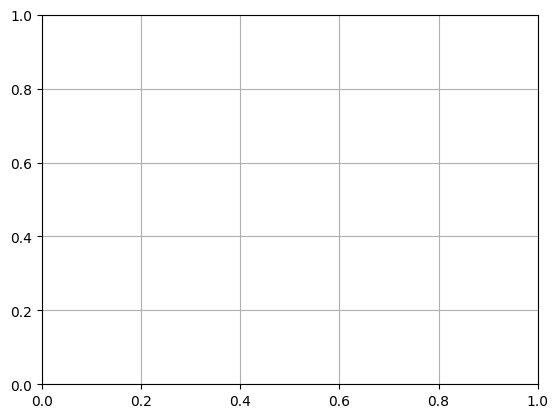

In [65]:
nudos = nudosUniformes(3, 6) # 6 datos
print(nudos)
dibujaFuncionesBase(3, 8, nudos) # 8 (6+2) puntos de control

***

### Generación de los puntos de control de la curva B-spline interpoladora

Dado el vector de puntos que se pretende interpolar y el vector de nudos, en esta fase calculamos los puntos de control de la curva Bspline que interpola dichos puntos. Los puntos a interpolar se corresponden con los valores de la curva en los nudos que se dibujan.

Si tenemos $k+1$ datos a interpolar, hacen falta $n+1=(k+2)+1$ puntos de control.

* Los parámetros de la función son:
    * datos: vector de puntos bidimensionales por los que debe pasar la curva B-spline.
    * nudos: vector de nudos en el que se apoya el cálculo de los puntos de control.

* El algoritmo consta de varios pasos que vamos a detallar a continuación:
    * Cálculo de alfa, beta y gamma
    * Cálculo de lambda y delta (paso *forward*)
    * Cálculo de los puntos de control internos: $P_1$ a $P_{n-1}$ (paso *backward*)
    * Creación del vector de puntos control con la repetición del primero y el último
    
***

Los puntos a interpolar son puntos de una curva Bspline con los cuales se hace corresponder un nudo del vector de nudos de la curva respectivamente. Por tanto, si los puntos a interpolar son $d_0, d_1, \ldots d_k$ se debe cumplir que:

$$
\begin{align}
d_0 & = p(u_3) \\
d_1 & = p(u_4) \\
\ldots  \\
d_{k-1} & = p(u_{k+2}) \\
d_k & = p(u_{k+3})
\end{align}
$$

Según esas condiciones, con $k+1$ puntos a interpolar, la curva necesita $k$ segmentos, o debe estar definida hasta el último punto a interpolar, que es $p(u_{k+3})$. Como la curva se define hasta $u = u_{n+1}$, tenemos que $n$ debe ser $n = k + 2$.

***

Necesitamos, por tanto, $k+3$ puntos de control, pero tenemos solo $k+1$ condiciones. Necesitamos dos condiciones más. Dichas condiciones pueden ser que el segundo punto de control sea igual al primero y que el penúltimo sea igual al último.

***

Con estas dos nuevas condiciones ya tenemos las $k+3$ condiciones para los $k+3$ puntos de control. Además, como buscamos una curva *clamped*, el primer punto de control coincide con el primer punto a interpolar y el último punto de control coincide con el último punto a interpolar. Con todo lo dicho, las condiciones que se deben cumplir son:

$$
\begin{align}
P_0 & = d_0 & \qquad \mbox{condición extra} \\
P_1 & = p(u_3) = d_0 & \qquad \mbox{curva $\mathit{clamped}$} \\
P_2 & = p(u_4) = d_1 \\
\ldots  \\
P_{k} & = p(u_{k+2}) = d_{k-1} \\
P_{k+1} & = p(u_{k+3}) = d_k & \qquad \mbox{curva $\mathit{clamped}$} \\
P_{k+2} & = d_k & \qquad \mbox{condición extra} \\
\end{align}
$$

***

Si tenemos en cuenta los valores de la curva en cualquier punto del parámetro $u$, sabemos que solo hay cuatro funciones base que son diferentes a 0 en cada punto. Pero, en concreto, en los nudos como mucho hay tres funciones base no nulas, ya que $N_{s,p}(u_s) = 0$, por lo que tenemos que:

\begin{equation}
p(u_{j+3}) = \sum_{i=0}^{k+2} P_i N_{i,3}(u_{j+3}) = d_j
\end{equation}

y si hacemos que:

$$\alpha_j = N_{j,3}(u_{j+3})$$ 
$$\beta_j =  N_{j+1,3}(u_{j+3})$$ 
$$\gamma_j=  N_{j+2,3}(u_{j+3})$$

entonces, las ecuaciones a partir de $p(u_4)$ hasta $p(u_{k+2})$ las podemos reescribir como:

$$P_i \alpha_i + P_{i+1} \beta_i + P_{i+2} \gamma_i = d_j$$

***
Veamos cómo son los valores de $\alpha_j, \beta_j, \gamma_j$ para $j=1,\ldots,k-1$. Para $u=u_{j+3}$ la única función base de grado 0 que tiene valor es $N_{j+3,0}(u_{j+3})$, por tanto, las funciones base de orden superior con valores distintos de 0 son:

***

$$\begin{matrix} 
 & 				& 			&		   	& N_{j,3}(u_{j+3})	\\ 
 & 				&			& N_{j+1,2}(u_{j+3}) 	& 			\\
 &				& N_{j+2,1}(u_{j+3}) 	&    		   	& N_{j+1,3}(u_{j+3})	\\
 & N_{j+3,0}(u_{j+3}) = 1	&			& N_{j+2,2}(u_{j+3}) 	& 			\\
 &				& N_{j+3,1}(u_{j+3}) 	&    		   	& N_{j+2,3}(u_{j+3})	\\
 & 				& 			& N_{j+3,2}(u_{j+3}) 	& 			\\
 & 				&			& 			& N_{j+3,3}(u_{j+3}) 
\end{matrix}$$

***

No obstante, sabemos que justo en $u=u_{j+3}$, tenemos que $$N_{j+3,1}(u_{j+3})=N_{j+3,2}(u_{j+3})=N_{j+3,3}(u_{j+3}) = 0$$

Teniendo en cuenta que:

$$N_{i,p}(u) = \frac{u-u_{i}}{u_{i+p} - u_{i}} \cdot N_{i,p-1}(u) + \frac{u_{i+p+1} - u}{u_{i+p+1} - u_{i+1}} \cdot N_{i+1,p-1}(u)$$

obtenemos los valores:

$$\alpha_j = N_{j,3}(u_{j+3}) = \frac{(u_{j+4}-u_{j+3})^2}{(u_{j+4}-u_{j+1})(u_{j+4}-u_{j+2})}$$

$$\beta_j = N_{j+1,3}(u_{j+3}) = \frac{(u_{j+3}-u_{j+1})(u_{j+4}-u_{j+3})}{(u_{j+4}-u_{j+1})(u_{j+4}-u_{j+2})} + \frac{(u_{j+5}-u_{j+3})(u_{j+3}-u_{j+2})}{(u_{j+5}-u_{j+2})(u_{j+4}-u_{j+2})}$$

$$\gamma_j = N_{j+2,3}(u_{j+3}) = \frac{(u_{j+3}-u_{j+2})^2}{(u_{j+5}-u_{j+2})(u_{j+4}-u_{j+2})}$$

In [ ]:
# Funciones para generar los puntos de control
# Calculo de alfa, beta, gamma donde:
# nudos == vector de nudos
# n_alfa == n_beta == n_gamma == n_data = numero de datos == numero de nudos - 2*p 
# p es el grado de la curva (p == 3)
def calculaAlfa(nudos):    
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo alfa
    # cuidado con las divisiones por 0!!
    #
    # alfa_0, alfa_1, ..., alfa_k-2, alfa_k-1
    # donde alfa_0 == alfa_k-1 == 0
    #
    # ========================== END YOUR CODE HERE =======================
    alfa = []
    return alfa

def calculaBeta(nudos):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo beta
    # cuidado con las divisiones por 0!!
    #
    # beta_0, beta_1, ..., beta_k-2, beta_k-1
    # donde beta_0 == beta_k-1 == 1
    #
    # ========================== END YOUR CODE HERE =======================
    beta = []
    return beta
    
def calculaGamma(nudos):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo gamma
    # cuidado con las divisiones por 0!!
    #
    # gamma_0, gamma_1, ..., gamma_k-2, gamma_k-1
    # donde gamma_0 == gamma_k-1 == 0
    #
    # ========================== END YOUR CODE HERE =======================
    gamma = []
    return gamma

Suponiendo que hemos calculado los valores de $\alpha$, $\beta$ y $\gamma$ que necesitamos, y sin tener en cuenta las dos condiciones extra que hemos introducido artificialmente, podemos escribir el sistema a resolver como:

$$
\begin{pmatrix}
1&0&0&0&\ldots&0 \\ 
\alpha_1&\beta_1&\gamma_1&0&\ldots&0 \\ 
0&\alpha_2&\beta_2&\gamma_2&\ldots&0 \\ 
\ldots&&\ldots&&\ldots& \\ 
0&0&\ldots&\alpha_{k-1}&\beta_{k-1}&\gamma_{k-1} \\ 
0&0&0&0&0&1
\end{pmatrix} 
\cdot 
\begin{pmatrix}
P_1\\ P_2\\ P_3\\ \ldots \\ P_k\\ P_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
d_0\\ d_1\\ d_2\\ \ldots \\ d_{k-1}\\ d_k
\end{pmatrix}
$$

Se trata de un sistema de ecuaciones tridiagonal que se puede resolver en dos pasos, paso adelante (*forward*), de forma que cada fila de la matriz se convierte en una fila con solo dos valores (uno en la diagonal y otro a su derecha), para lo que se resta a cada línea de la matriz (a cada ecuación) la línea superior multiplicada por un escalar para anular el valor a la izquierda de la diagonal.

$$
\begin{pmatrix}
1&0&0&0&\ldots&0 \\ 
0&1&\lambda_1&0&\ldots&0 \\ 
0&0&1&\lambda_2&\ldots&0 \\ 
\ldots&&\ldots&&\ldots& \\ 
0&0&\ldots&0&1&\lambda_{k-1} \\ 
0&0&0&0&0&1
\end{pmatrix} 
\cdot 
\begin{pmatrix}
P_1\\ P_2\\ P_3\\ \ldots \\ P_k\\ P_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
d_0\\ \delta_1\\ \delta_2\\ \ldots \\ \delta_{k-1}\\ d_k
\end{pmatrix}
$$

Para ello se realizan los cálculos:

$\lambda_0 = 0$ <br>
`para` $j = 1$ `hasta` $k-1$ <br>
$\qquad \lambda_j = \frac{\gamma_j}{\beta_j - \alpha_j \lambda_{j-1}}$

$\delta_0 = d_0$ <br>
`para` $j = 1$ `hasta` $k$ <br>
$\qquad \delta_j = \frac{d_j - \alpha_j \delta_{j-1}}{beta_j - \alpha_j \lambda_{j-1}}$

donde $d_j$ es $datos_j$.

In [20]:
# Funciones para generar los puntos de control: Paso forward
# Calculo de lambda y delta donde:
# n_lambda == n_data - 1 
# n_delta  == n_data = numero de datos
# data == conjunto de datos que interpola la curva Bspline (datos de entrada)
def calculaLambda(alfa, beta, gamma):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo lambda
    # cuidado con las divisiones por 0!!
    #
    # lambda_0, lambda_1, ..., lambda_k-3, lambda_k-2
    # donde lambda_0 == (gamma_0 / beta_0) == (0/1) == 0
    #
    # ========================== END YOUR CODE HERE =======================
    f_lambda = []
    return f_lambda
    
def calculaDelta(alfa, beta, f_lambda, data):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo delta (puntos de igual dimension que 'data')
    # cuidado con las divisiones por 0!!
    #
    # delta_0, delta_1, ..., delta_k-2, delta_k-1
    # donde delta_0 == (data_0 / beta_0) == (data_0/1) == data_0 (punto)
    #
    # ========================== END YOUR CODE HERE =======================
    f_delta = []
    return f_delta

Una vez calculados los valores de $\lambda_j$ y $\delta_j$, podemos lograr directamente los valores de $P_i$. Para ello, tenemos que ejecutar un ciclo de atrás hacia adelante (paso *backward*).

$P_{k+1} = d_k$ <br>
`para` $j = k$ `hasta` $1$ <br>
$\qquad P_j = \delta_{j-1} - \lambda_{j-1} P_{j+1}$

donde $d_j$ es $datos_j$.

In [21]:
# Funciones para generar los puntos de control: Paso backward
# Calculo de X donde:
# n_X == n_data = numero de datos
# Pueden serte utiles las funciones: np.flip() y np.vstack()
def calculaBackward(f_lambda, f_delta):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Calculo X
    # cuidado con las divisiones por 0!!
    #
    # X_0, X_1, ..., X_k-2, X_k-1
    #
    # ========================== END YOUR CODE HERE =======================
    b_X = [] 
    return b_X

Finalmente se obtiene el vector de puntos de control repitiendo el primer y último valor de los puntos de control obtenidos.

In [22]:
### Creación del vector de puntos control con la repetición del primero y del último
# data == conjunto de datos que interpola la curva Bspline (datos de entrada)
# nudos == vector de nudos
def puntosControlBspline(data, nudos):    
    alfa  = calculaAlfa(nudos)
    #print("alfa ", len(alfa))
    #print(alfa)
    beta  = calculaBeta(nudos)
    #print("beta", len(beta))
    #print(beta)
    gamma = calculaGamma(nudos)
    #print("gamma", len(gamma))
    #print(gamma)
    
    ## Paso forward
    f_lambda = calculaLambda(alfa, beta, gamma)
    #print("lambda", len(f_lambda))
    #print(f_lambda)
    f_delta = calculaDelta(alfa, beta, f_lambda, data)
    #print("delta", len(f_delta))
    #print(f_delta)
    
    ## Paso backward
    b_X = calculaBackward(f_lambda, f_delta)
    #print("X", len(b_X))
    #print(b_X)
            
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Incluir en el resultado el primer y el ultimo punto de control
    # P_{k+2}, P_0
    #
    # ========================== END YOUR CODE HERE =======================
    ptosControl = []
    return ptosControl

### Verificación de la primera fase (nudos uniformes)

#### Test 1

9
[]
[]


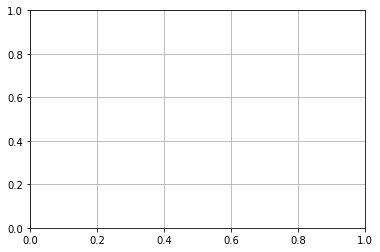

In [23]:
### Test 1
data = creaDatosPrueba(1)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline uniforme para evaluar la tercera fase (a continuacion)

# Bspline uniforme
nudos_uniforme1 = nudosUniformes(3, n_data)
print(nudos_uniforme1)

# Puntos de control de la Bspline uniforme
control_uniforme1 = puntosControlBspline(data, nudos_uniforme1)
print(control_uniforme1)

# Puntos de control de la Bspline uniforme
dibujaBspline(3, control_uniforme1, nudos_uniforme1, 50, data)

# Funciones base de la Bspine uniforme
dibujaFuncionesBase(3, len(control_uniforme1), nudos_uniforme1)

#### Test 2

4
[]
[]


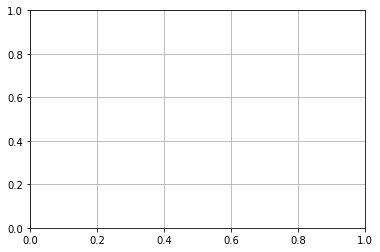

In [24]:
### Test 2
data = creaDatosPrueba(2)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline uniforme para evaluar la tercera fase (a continuacion)

# Bspline uniforme
nudos_uniforme2 = nudosUniformes(3, n_data)
print(nudos_uniforme2)

# Puntos de control de la Bspline uniforme
control_uniforme2 = puntosControlBspline(data, nudos_uniforme2)
print(control_uniforme2)

# Puntos de control de la Bspline uniforme
dibujaBspline(3, control_uniforme2, nudos_uniforme2, 50, data)

# Funciones base de la Bspine uniforme
dibujaFuncionesBase(3, len(control_uniforme2), nudos_uniforme2)

#### Test 3

4
[]
[]


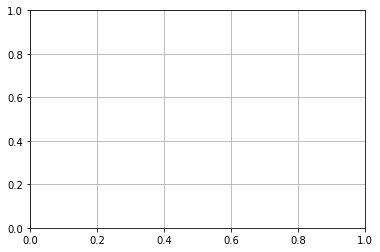

In [25]:
### Test 3
data = creaDatosPrueba(3)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline uniforme para evaluar la tercera fase (a continuacion)

# Bspline uniforme
nudos_uniforme3 = nudosUniformes(3, n_data)
print(nudos_uniforme3)

# Puntos de control de la Bspline uniforme
control_uniforme3 = puntosControlBspline(data, nudos_uniforme3)
print(control_uniforme3)

# Puntos de control de la Bspline uniforme
dibujaBspline(3, control_uniforme3, nudos_uniforme3, 50, data)

# Funciones base de la Bspine uniforme
dibujaFuncionesBase(3, len(control_uniforme3), nudos_uniforme3)

## Fase 2: Creación de nudos no uniformes

En este caso trataremos de obtener un espacio no uniforme que tiene en cuenta la distancia entre los datos a interpolar (geometría de los datos).

Si la curva interpoladora se acerca mucho al polígono formado por los puntos a interpolar (datos), la longitud del segmento de curva entre dos datos adyacentes es igual a la longitud de la cuerda entre estos dos puntos.

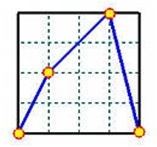

Dados los datos $d_0, d_1,\ldots,d_k$. La longitud entre los datos $d_{i-1}$ y $d_i$ es: $\left\vert d_{i}-d_{i-1}\right\vert$ y la longitud del polígono de datos es la suma de las longitudes de estas cuerdas: $$L=\sum_{i=1}^{k} \left\vert d_{i}-d_{i-1}\right\vert$$

La relación entre la longitud de la cuerda del dato $d_0$ a $d_k$ con respecto a la longitud total del polígono es: $$L_{l}=\frac{\sum_{i=1}^{l}\left\vert d_{i}-d_{i-1}\right\vert}{L}$$

Si el dominio de los nudos es $[0,1]$:
$$u_0=u_1=u_2=u_3=0$$

$$u_{l+3}=L_{l}=\frac{1}{L}\sum_{i=1}^{l}\left\vert d_{i}-d_{i-1}\right\vert \qquad 0<l<k-3$$
                                                     
$$u_{k-3}=u_{k-2}=u_{k-1}=u_{k}=1$$

El espaciado de los nudos es proporcional a la distancia entre los puntos de los datos lo cual da lugar a Bsplines no uniformes. Se suele utilizar para el suavizado de las curvas.

***

Para el caso del espaciado no uniforme *centrípeta* y dados los datos $d_0, d_1,\ldots,d_k$. La longitud entre los datos $d_{i-1}$ y $d_i$ es: $\left\vert d_{i}-d_{i-1}\right\vert^a$ y la longitud del polígono de datos es la suma de las longitudes de estas cuerdas: $$L=\sum_{i=1}^{k} \left\vert d_{i}-d_{i-1}\right\vert^a$$ donde $a$ es un parámetro dado que define la curva Bspline de espaciado *centrípeta*.

La relación entre la longitud de la cuerda del dato $d_0$ a $d_k$ con respecto a la longitud total del polígono es: $$L_{l}=\frac{\sum_{i=1}^{l}\left\vert d_{i}-d_{i-1}\right\vert^a}{L}$$

Si el dominio de los nudos es $[0,1]$:
$$u_0=u_1=u_2=u_3=0$$

$$u_{l+3}=L_{l}=\frac{1}{L}\sum_{i=1}^{l}\left\vert d_{i}-d_{i-1}\right\vert^a \qquad 0<l<k-3$$
                                                     
$$u_{k-3}=u_{k-2}=u_{k-1}=u_{k}=1$$

***

Si el parámetro $a=1$, el método *centrípeta* es el método de la longitud de la cuerda(*chord-length*).

Si $a<1$ (por ejemplo, $a=1/2$), se cumple que: $$\left\vert d_{i}-d_{i-1}\right\vert^a<\left\vert d_{i}-d_{i-1}\right\vert$$

Es decir, el impacto de una cuerda larga (es decir, longitud > 1) sobre la longitud del polígono de datos se reduce. Mientras que el impacto de una cuerda corta (es decir, longitud < 1) sobre la longitud del polígono de datos aumenta.

***

En función del parámetro $exponente$, esta función devuelve el vector de nudos con distribución:
 * centrípeta ($exponente < 1.0$)
 * *chord-length* ($exponente=1.0$)

In [26]:
### Funcion de creacion de nudos no uniformes
def nudosNoUniformes(p, data, exponente=1.0):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Genera el vector de nudos no uniforme clamped donde:
    #    * data == conjunto de datos que interpola la curva Bspline (datos de entrada)
    #    * k+1 es el numero de datos
    #    * p es el grado de la curva (p==3, Bspline cubica)
    #    * n+1 es el numero de puntos de control donde n = (k + 2)
    #    * m+1 es el numero de nudos donde m = n + p + 1 = (k + 2) + p + 1 y
    #    * si p = 3, entonces m = k + 6
    #
    # Si exponente < 1.0 ==> Bspline centripeta
    # Sino ==> Bspline chord-length
    #
    # ========================== END YOUR CODE HERE =======================
    nudos = []
    return nudos

### Ejemplo: *Chord-Length*

Sean $d_0=(0,0), d_1=(1,2), d_2=(3,4)$ y $d_3=(4,0)$. 

<img src='./images/LTVZ4R04.jpg'/>

$$
\left\vert d_{1}-d_{0}\right\vert =\sqrt{5}=2.236 \\
\left\vert d_{2}-d_{1}\right\vert = 2\sqrt{2}=2.828 \\
\left\vert d_{3}-d_{2}\right\vert =\sqrt{17}=4.123 \\
L=\sqrt{5}+2\sqrt{2}+\sqrt{17}=9.8176
$$

El valor de los nudos es:

$$
u_0=u_1=u_2=u_3=0 \\
u_4=\frac{\left\vert d_{1}-d_{0}\right\vert }{L}=\frac{2.236}{9.8176}=0.227 \\
u_5=\frac{\left\vert d_{1}-d_{0}\right\vert +\left\vert d_{2}-d_{1}\right\vert }{L}=\frac{2.236+2.828}{9.8176}=0.515 \\
u_{k-3}=u_{k-2}=u_{k-1}=u_{k}=1
$$

Este método suele utilizarse frecuentemente aunque, en alguna ocasión, la existencia de una cuerda de gran longitud puede dar lugar a una mala aproximación ya que puede producirse una “protuberancia” innecesaria en la curva.

<img align="center" width="360" src="./images/LTVZ4R03.jpg"/>

### Ejemplo: *Centripeta*

Sean $d_0=(0,0), d_1=(1,2), d_2=(3,4)$ y $d_3=(4,0)$ y el parámetro $a=\frac{1}{2}$.

<img src='./images/LTVZ4R04.jpg'/>

$$
\left\vert d_{1}-d_{0}\right\vert^{\frac{1}{2}} =\sqrt{\sqrt{5}}=1.495 \\
\left\vert d_{2}-d_{1}\right\vert^{\frac{1}{2}} =\sqrt{2\sqrt{2}}=1.682 \\
\left\vert d_{3}-d_{2}\right\vert^{\frac{1}{2}} =\sqrt{\sqrt{17}}=2.031 \\
L=\sqrt{\sqrt{5}}+\sqrt{2\sqrt{2}}+\sqrt{\sqrt{17}}=5.208
$$

El valor de los nudos es:

$$
u_0=u_1=u_2=u_3=0 \\
u_4=\frac{\left\vert d_{1}-d_{0}\right\vert^a}{L}=\frac{1.495}{5.208}=0.2871 \\
u_5=\frac{\left\vert d_{1}-d_{0}\right\vert +\left\vert d_{2}-d_{1}\right\vert }{L}=\frac{1.495+1.682}{5.208}=0.6101 \\
u_{k-3}=u_{k-2}=u_{k-1}=u_{k}=1
$$

***

En este caso puede apreciarse el buen comportamiento de la interpolación según el método “centripeta”.

<img align="center" width="360" src="./images/LTVZ4R05.jpg"/>

*** 

Sin embargo, no podemos hablar de un método eficiente en concreto. En este caso, puede observarse que la mejor aproximación la da el método de “uniformemente espaciado”.

<img align="center" width="360" src="./images/LTVZ4R06.jpg"/>

### Verificación de la segunda fase (nudos no uniformes)

#### Test 1 *chord-length*

9
[]
[]


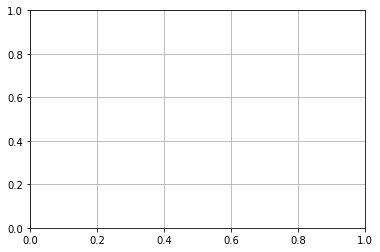

In [27]:
### Test 1
data = creaDatosPrueba(1)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "chord length"
nudos_chord1 = nudosNoUniformes(3, data)
print(nudos_chord1)

# Puntos de control de la Bspline no uniforme
control_chord1 = puntosControlBspline(data, nudos_chord1)
print(control_chord1)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_chord1, nudos_chord1, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_chord1), nudos_chord1)

#### Test 2 *chord-length*

4
[]
[]


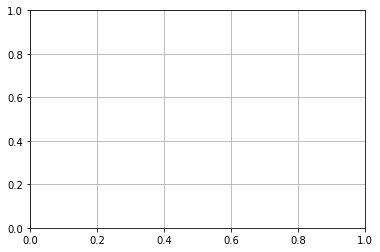

In [28]:
### Test 2
data = creaDatosPrueba(2)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "chord length"
nudos_chord2 = nudosNoUniformes(3, data)
print(nudos_chord2)

# Puntos de control de la Bspline no uniforme
control_chord2 = puntosControlBspline(data, nudos_chord2)
print(control_chord2)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_chord2, nudos_chord2, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_chord2), nudos_chord2)

#### Test 3 *chord-length*

4
[]
[]


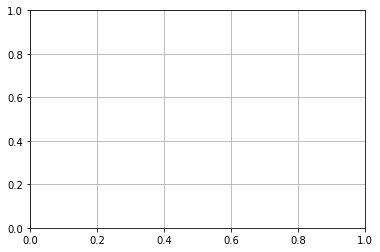

In [29]:
### Test 3
data = creaDatosPrueba(3)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "chord length"
nudos_chord3 = nudosNoUniformes(3, data)
print(nudos_chord3)

# Puntos de control de la Bspline no uniforme
control_chord3 = puntosControlBspline(data, nudos_chord3)
print(control_chord3)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_chord3, nudos_chord3, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_chord3), nudos_chord3)

#### Test 1 *centripeta*

9
[]
[]


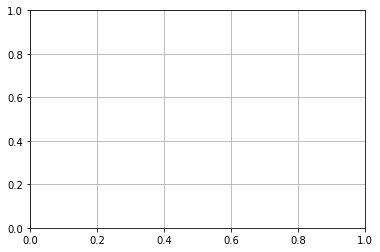

In [30]:
### Test 1
data = creaDatosPrueba(1)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "centripeta"
nudos_centripeta1 = nudosNoUniformes(3, data, 0.5)
print(nudos_centripeta1)

# Puntos de control de la Bspline no uniforme
control_centripeta1 = puntosControlBspline(data, nudos_centripeta1)
print(control_centripeta1)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_centripeta1, nudos_centripeta1, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_centripeta1), nudos_centripeta1)

#### Test 2 *centripeta*

4
[]
[]


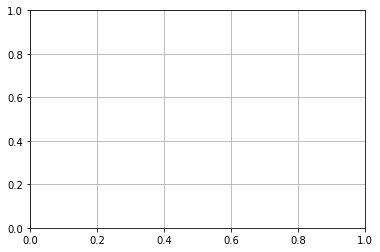

In [31]:
### Test 2
data = creaDatosPrueba(2)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "centripeta"
nudos_centripeta2 = nudosNoUniformes(3, data, 0.5)
print(nudos_centripeta2)

# Puntos de control de la Bspline no uniforme
control_centripeta2 = puntosControlBspline(data, nudos_centripeta2)
print(control_centripeta2)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_centripeta2, nudos_centripeta2, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_centripeta2), nudos_centripeta2)

#### Test 3 *centripeta*

4
[]
[]


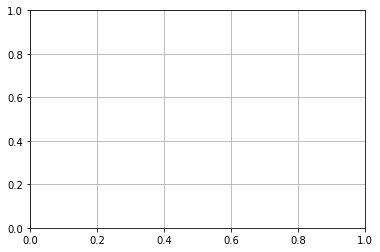

In [32]:
### Test 3
data = creaDatosPrueba(3)
n_data = len(data)
print(n_data)

# Guardo los puntos de control y los nudos de esta Bspline no uniforme para evaluar la tercera fase (a continuacion)

# Bspline no uniforme "centripeta"
nudos_centripeta3 = nudosNoUniformes(3, data, 0.5)
print(nudos_centripeta3)

# Puntos de control de la Bspline no uniforme
control_centripeta3 = puntosControlBspline(data, nudos_centripeta3)
print(control_centripeta3)

# Puntos de control de la Bspline no uniforme
dibujaBspline(3, control_centripeta3, nudos_centripeta3, 50, data)
              
# Funciones base de la Bspine no uniforme
dibujaFuncionesBase(3, len(control_centripeta3), nudos_centripeta3)

## Fase 3: Derivada de una curva Bspline

En este caso hay que implementar una función para obtener la derivada de una curva Bspline donde:

* Parámetros:
    * *control*: vector de puntos de la curva Bspline
    * *nudos*: vector de nudos de la curva Bspline

Para curvas *clamped* se cumple que los puntos de control de su derivada se obtienen de la siguiente forma:
$$
\begin{equation}
p'(u) = \sum_{i=0}^{n-1}q_i N_{i,p-1}(u)
\end{equation}
$$

donde

$$
\begin{equation}
q_i = \frac{p}{u_{i+p+1}-u_{i+1}}(p_{i+1}-p_i)
\end{equation}
$$

y el vector de nudos sobre el que se definen las funciones base $N_{i,p-1}(u)$ es como el vector de nudos de la curva $p(u)$ al que se le quitan el primer y el último nudo.

In [33]:
### Derivada de una curva Bspline
def bsplineDerivada(p, ptosControl, nudos):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Obtener los puntos de control de la derivada
    #
    # ========================== END YOUR CODE HERE =======================
    ptosControlDerivada = []
    return ptosControlDerivada

In [34]:
### Nudos de la curva Bspline derivada
def nudosDerivada(nudos):
    # ========================== PUT YOUR CODE HERE =======================
    #
    # Obtener los nudos de la derivada
    #
    # ========================== END YOUR CODE HERE =======================
    nudosDerivada = []
    return nudosDerivada

### Verificación (derivada)

#### Test 1 uniforme


[]
[]


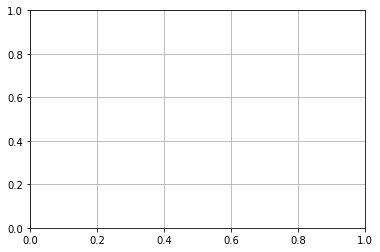

In [35]:
# Puntos de control de la curva derivada (uniforme)
controlDerivada_uniforme1 = bsplineDerivada(3, control_uniforme1, nudos_uniforme1)
print(controlDerivada_uniforme1)
# Nudos de la curva derivada (uniforme)
nudosDerivada_uniforme1 = nudosDerivada(nudos_uniforme1)
print(nudosDerivada_uniforme1)
# Dibuja la curva derivada (uniforme)
dibujaBspline(2, controlDerivada_uniforme1, nudosDerivada_uniforme1)
# Dibuja las funciones base de la curva derivada (uniforme)
dibujaFuncionesBase(2, len(controlDerivada_uniforme1), nudosDerivada_uniforme1)

#### Test 1 *chord-length*

[]
[]


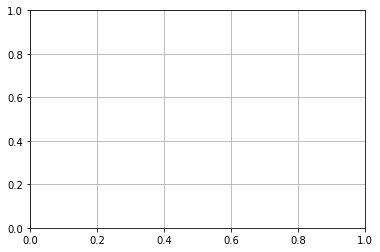

In [36]:
# Puntos de control de la curva derivada (*chord-length*)
controlDerivada_chord1 = bsplineDerivada(3, control_chord1, nudos_chord1)
print(controlDerivada_chord1)
# Nudos de la curva derivada (*chord-length*)
nudosDerivada_chord1 = nudosDerivada(nudos_chord1)
print(nudosDerivada_chord1)
# Dibuja la curva derivada (*chord-length*)
dibujaBspline(2, controlDerivada_chord1, nudosDerivada_chord1)
# Dibuja las funciones base de la curva derivada (*chord-length*)
dibujaFuncionesBase(2, len(controlDerivada_chord1), nudosDerivada_chord1)

#### Test 1 *centripeta*

[]
[]


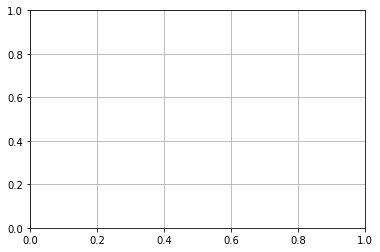

In [37]:
# Puntos de control de la curva derivada (*centripeta*)
controlDerivada_centripeta1 = bsplineDerivada(3, control_centripeta1, nudos_centripeta1)
print(controlDerivada_centripeta1)
# Nudos de la curva derivada (*centripeta*)
nudosDerivada_centripeta1 = nudosDerivada(nudos_centripeta1)
print(nudosDerivada_centripeta1)
# Dibuja la curva derivada (*centripeta*)
dibujaBspline(2, controlDerivada_centripeta1, nudosDerivada_centripeta1)
# Dibuja las funciones base de la curva derivada (*centripeta*)
dibujaFuncionesBase(2, len(controlDerivada_centripeta1), nudosDerivada_centripeta1)

#### Test 2 uniforme

[]
[]


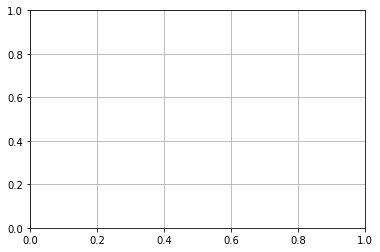

In [38]:
# Puntos de control de la curva derivada (uniforme)
controlDerivada_uniforme2 = bsplineDerivada(3, control_uniforme2, nudos_uniforme2)
print(controlDerivada_uniforme2)
# Nudos de la curva derivada (uniforme)
nudosDerivada_uniforme2 = nudosDerivada(nudos_uniforme2)
print(nudosDerivada_uniforme2)
# Dibuja la curva derivada (uniforme)
dibujaBspline(2, controlDerivada_uniforme2, nudosDerivada_uniforme2)
# Dibuja las funciones base de la curva derivada (uniforme)
dibujaFuncionesBase(2, len(controlDerivada_uniforme2), nudosDerivada_uniforme2)

#### Test 2 *chord-length*

[]
[]


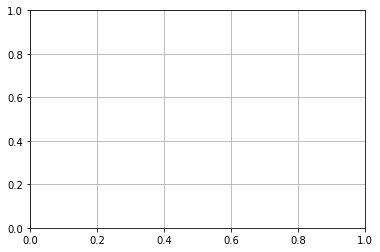

In [39]:
# Puntos de control de la curva derivada (*chord-length*)
controlDerivada_chord2 = bsplineDerivada(3, control_chord2, nudos_chord2)
print(controlDerivada_chord2)
# Nudos de la curva derivada (*chord-length*)
nudosDerivada_chord2 = nudosDerivada(nudos_chord2)
print(nudosDerivada_chord2)
# Dibuja la curva derivada (*chord-length*)
dibujaBspline(2, controlDerivada_chord2, nudosDerivada_chord2)
# Dibuja las funciones base de la curva derivada (*chord-length*)
dibujaFuncionesBase(2, len(controlDerivada_chord2), nudosDerivada_chord2)

#### Test 2 *centripeta*

[]
[]


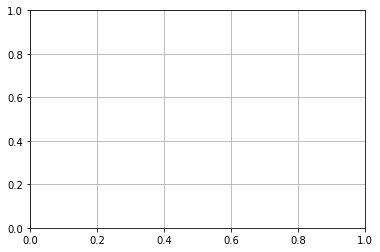

In [40]:
# Puntos de control de la curva derivada (*centripeta*)
controlDerivada_centripeta2 = bsplineDerivada(3, control_centripeta2, nudos_centripeta2)
print(controlDerivada_centripeta2)
# Nudos de la curva derivada (*centripeta*)
nudosDerivada_centripeta2 = nudosDerivada(nudos_centripeta2)
print(nudosDerivada_centripeta2)
# Dibuja la curva derivada (*centripeta*)
dibujaBspline(2, controlDerivada_centripeta2, nudosDerivada_centripeta2)
# Dibuja las funciones base de la curva derivada (*centripeta*)
dibujaFuncionesBase(2, len(controlDerivada_centripeta2), nudosDerivada_centripeta2)

#### Test 3 uniforme

[]
[]


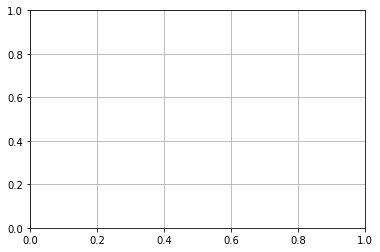

In [41]:
# Puntos de control de la curva derivada (uniforme)
controlDerivada_uniforme3 = bsplineDerivada(3, control_uniforme3, nudos_uniforme3)
print(controlDerivada_uniforme3)
# Nudos de la curva derivada (uniforme)
nudosDerivada_uniforme3 = nudosDerivada(nudos_uniforme3)
print(nudosDerivada_uniforme3)
# Dibuja la curva derivada (uniforme)
dibujaBspline(2, controlDerivada_uniforme3, nudosDerivada_uniforme3)
# Dibuja las funciones base de la curva derivada (uniforme)
dibujaFuncionesBase(2, len(controlDerivada_uniforme3), nudosDerivada_uniforme3)

#### Test 3 *chord-length*

[]
[]


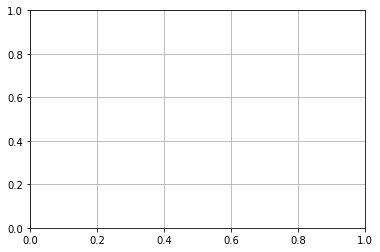

In [42]:
# Puntos de control de la curva derivada (*chord-length*)
controlDerivada_chord3 = bsplineDerivada(3, control_chord3, nudos_chord3)
print(controlDerivada_chord3)
# Nudos de la curva derivada (*chord-length*)
nudosDerivada_chord3 = nudosDerivada(nudos_chord3)
print(nudosDerivada_chord3)
# Dibuja la curva derivada (*chord-length*)
dibujaBspline(2, controlDerivada_chord3, nudosDerivada_chord3)
# Dibuja las funciones base de la curva derivada (*chord-length*)
dibujaFuncionesBase(2, len(controlDerivada_chord3), nudosDerivada_chord3)

#### Test 3 *centripeta*

[]
[]


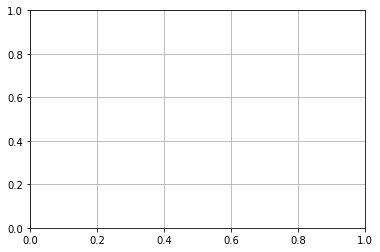

In [43]:
# Puntos de control de la curva derivada (*centripeta*)
controlDerivada_centripeta3 = bsplineDerivada(3, control_centripeta3, nudos_centripeta3)
print(controlDerivada_centripeta3)
# Nudos de la curva derivada (*centripeta*)
nudosDerivada_centripeta3 = nudosDerivada(nudos_centripeta3)
print(nudosDerivada_centripeta3)
# Dibuja la curva derivada (*centripeta*)
dibujaBspline(2, controlDerivada_centripeta3, nudosDerivada_centripeta3)
# Dibuja las funciones base de la curva derivada (*centripeta*)
dibujaFuncionesBase(2, len(controlDerivada_centripeta3), nudosDerivada_centripeta3)

# Bibliografía

* John C. Beatty, Richard H. Bartels, and Brian A. Barsky. An Introduction to Splines for Use in Computer Graphics and Geometric Modeling. Morgan Kaufmann, 1 edition, 1989.

* Sambhunath Biswas and Brian C. Lovell. Bézier and Splines in Image Processing and Machine Vision. Springer, 1 edition, December 2008.

* Les A. Piegl and Wayne Tiller. The NURBS Book. Springer, 2nd edition, November 1997.

* David Salomon. Curves and Surfaces for Computer Graphics. Springer, 1 edition, September 2006.

* M. Sarfraz. Interactive Curve Modeling: With Applications to Computer Graphics, Vision and Image Processing. Springer, 1 edition, October 2007.

* C.K. Shene. CS3621. introduction to computing with geometry notes.

* Alan Watt and Mark Watt. Advanced Animation and Rendering Techniques. AMC Press, Addison-Wesley, New York, 1992